In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""This notebook creates the statistics of TAG in Spain in YEAR"""

import inspect, os, sys

try :
    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

except :
    current_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))
    folder_parts = current_folder.split(os.sep)
    pywikibot_folder = os.sep.join(folder_parts[:-1])

    if current_folder not in sys.path:
        sys.path.insert(0, current_folder)
    if pywikibot_folder not in sys.path:
        sys.path.insert(0, pywikibot_folder)

    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

import mwparserfromhell as mwh

In [2]:
from modules.wmtools import upload_to_commons, \
                            get_registration_time, \
                            heat_color, \
                            get_project_name, \
                            wrap_label

In [3]:
import pandas as pd
import numpy as np
from mako.template import Template
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from urllib.parse import urlencode
import requests
import json
from itertools import groupby
from operator import itemgetter
from functools import reduce
import math
import random

In [4]:
from geojson import Feature, Point, FeatureCollection
import geojson

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

In [6]:
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans',
                                  'Bitstream Vera Sans',
                                  'Computer Modern Sans Serif',
                                  'Lucida Grande',
                                  'Verdana',
                                  'Geneva',
                                  'Lucid',
                                  'Arial',
                                  'Helvetica',
                                  'Avant Garde',
                                  'sans-serif']

In [7]:
# Project parameters
YEAR                = 2017
TAG                 = 'WLE'
TAG_EXT             = "Wiki Loves Earth"

BASE_NAME           = "Commons:Wiki Loves in Spain/{1}/{0}".format(YEAR, TAG_EXT)
LOG_PAGE            = BASE_NAME + '/Log'
STATISTICS_PAGE     = BASE_NAME + '/Stats'
GALLERY_QI          = BASE_NAME + '/QI'
BASE_SCI_DB_NAME    = "Commons:Wiki Loves Earth 2016 in Spain"
SCI_DB_PAGE         = BASE_SCI_DB_NAME + "/SCI DB"

VALID_NAMESPACES    = ['0', '4', '100', '104']
DAYS_BEFORE_REGISTRATION = 15

WLE_FINALIST_CATEGORY = "Category:Images from {1} {0} in Spain (finalists)".format(YEAR, TAG_EXT)

commons_site = pb.Site('commons', 'commons')

In [8]:
# Base URL for interacting with MediaWiki API
MW_API_BASE_URL     = 'https://commons.wikimedia.org/w/api.php'
MW_API_QUERY_STRING = {"action": "query",
                       "format": "json",
                       "gulimit": "500",
                       "prop": "globalusage",
                       "guprop": "url|namespace",
                       "titles": None
                      }

In [9]:
# Different sizes for the images created
figsize=[15., 10.]
figsize_half=[8., 10.]
figsize_high=[15., 30.]
figsize_low=[15., 6.]

In [10]:
# Folder management (templates, images...)
cwd = os.getcwd()

images_directory = os.path.join(cwd, 'images')
if not os.path.exists(images_directory):
    os.makedirs(images_directory)
    
templates_directory = os.path.join(cwd, 'templates')

In [11]:
now = (datetime.now().strftime("%Y-%m-%d"))

In [12]:
# Template for image description
plot_description = """== {{{{int:filedesc}}}} ==
{{{{Information
|description={{{{en|{2}}}}}
|source={{{{own}}}}
|author=[[User:Discasto|Discasto]]
|date={3}
}}}}

{{{{Created with Matplotlib}}}}

== {{{{int:license-header}}}} ==
{{{{self|cc-by-sa-4.0}}}}

[[Category:Photos by User:Discasto]]
[[Category:{0} {1} in Spain]]"""

In [13]:
annexes = {
   'ES-AN': [u'Anexo:Lugares de importancia comunitaria de Andalucía', 'Andalusia'],
   'ES-AR': [u'Anexo:Lugares de importancia comunitaria de Aragón', 'Aragon'],
   'ES-AS': [u'Anexo:Lugares de importancia comunitaria de Asturias', 'Asturias'],
   'ES-CB': [u'Anexo:Lugares de importancia comunitaria de Cantabria', 'Cantabria'],
   'ES-CM': [u'Anexo:Lugares de importancia comunitaria de Castilla-La Mancha', 'Castile-La Mancha'],
   'ES-CL': [u'Anexo:Lugares de importancia comunitaria de Castilla y León', u'Castile and León'],
   'ES-CT': [u'Anexo:Lugares de importancia comunitaria de Cataluña', 'Catalonia'],
   'ES-MD': [u'Anexo:Lugares de importancia comunitaria de la Comunidad de Madrid', 'Community of Madrid'],
   'ES-VC': [u'Anexo:Lugares de importancia comunitaria de la Comunidad Valenciana', 'Valencian Community'],
   'ES-EX': [u'Anexo:Lugares de importancia comunitaria de Extremadura', 'Extremadura'],
   'ES-IB': [u'Anexo:Lugares de importancia comunitaria de las Islas Baleares', 'Balearic Islands'],
   'ES-CN': [u'Anexo:Lugares de importancia comunitaria de las Islas Canarias', 'Canary Islands'],
   'ES-GA': [u'Anexo:Lugares de importancia comunitaria de Galicia', 'Galicia'],
   'ES-RI': [u'Anexo:Lugares de importancia comunitaria de La Rioja', 'La Rioja'],
   'ES-NC': [u'Anexo:Lugares de importancia comunitaria de Navarra', 'Navarre'],
   'ES-MC': [u'Anexo:Lugares de importancia comunitaria de la Región de Murcia', 'Region of Murcia'],
   'ES-PV': [u'Anexo:Lugares de importancia comunitaria del País Vasco', 'Basque Country'],
   'ES-ML': [u'Anexo:Lugares de importancia comunitaria de Ceuta y Melilla', 'Melilla'],
   'ES-CE': [u'Anexo:Lugares de importancia comunitaria de Ceuta y Melilla', 'Ceuta'],
   'ES-MAGRAMA': [u'Anexo:Lugares de importancia comunitaria del MAGRAMA', 'MAGRAMA']
}

In [14]:
# Seaborn palette for autonomous communities
autcom_palette = [i[1:] for i in sns.color_palette('hls', 20).as_hex()]
autcoms = [annexes[key][1] for key in annexes]
autcom_colors = {autcom: autcom_palette[i] for i, autcom in enumerate(autcoms)}
autcom_colors

{'Andalusia': 'db5f57',
 'Aragon': 'db8657',
 'Asturias': 'dbae57',
 'Balearic Islands': '57d3db',
 'Basque Country': 'c957db',
 'Canary Islands': '57acdb',
 'Cantabria': 'dbd657',
 'Castile and León': '91db57',
 'Castile-La Mancha': 'b9db57',
 'Catalonia': '69db57',
 'Ceuta': 'db579e',
 'Community of Madrid': '57db6c',
 'Extremadura': '57dbbb',
 'Galicia': '5784db',
 'La Rioja': '575cdb',
 'MAGRAMA': 'db5777',
 'Melilla': 'db57c6',
 'Navarre': '7957db',
 'Region of Murcia': 'a157db',
 'Valencian Community': '57db94'}

## Auxiliary functions

In [67]:
def expand_itemid (_list):
    new_list = [{"itemid": i, "name": sci_df[sci_df['code'] == i]['name'].values[0]} for i in _list]
    if len(new_list) > 0:
        new_list = sorted(new_list, key=lambda k: k['name']) 
    return new_list

def decode_list (_list) :
    try:
        new_list = _list[:]
    except :
        new_list = []
    return new_list

In [16]:
def to_geojson (row) :
    """For each site of community importance, identified by row['code'], this function
    creates a proper GeoJSON Feature"""
    images_subset_df = images_df[(images_df['code'] == row['code']) & (images_df['width'] > images_df['height'])]
    if len (images_subset_df.index) == 0:
        images_subset_df = images_df[images_df['code'] == row['code']]

    if len(images_subset_df[images_subset_df['qi'] == 'qi']) > 0 :
        popup_image = images_subset_df[images_subset_df['qi'] == 'qi'].sample(1, random_state=0)['image_title'].values[0]
    elif len(images_subset_df[images_subset_df['finalist'] == 'finalist']) > 0 :
        popup_image = images_subset_df[images_subset_df['finalist'] == 'finalist'].sample(1, random_state=0)['image_title'].values[0]
    else :
        popup_image = images_subset_df.sample(1, random_state=0)['image_title'].values[0]

    properties = {"description": "[[File:{0}|150px]]".format(popup_image),
                  "title": "[[:Category:Images of a site of community importance with code {0} from {2} {1} in Spain|{3}]]".format(row['code'], YEAR, TAG_EXT, row['name']),
                  "marker-size": "small",
                  "marker-symbol": "circle",
                  "marker-color": autcom_colors[row['aut_com']]}

    feature = Feature(geometry=Point((row['longitude'], row['latitude'])), 
                      properties=properties
                     )
    return feature

## Retrieval of the sites of community importance

In [17]:
# retrieval of the WLE SCI (site of community importance) log
pb.output('Retrieving --> WLE SCI list')
sci_list_page = pb.Page(commons_site, SCI_DB_PAGE)
sci_list_text = StringIO(sci_list_page.text[sci_list_page.text.find('\n') + 
                                                      1:sci_list_page.text.rfind('\n')])
sci_df = pd.read_csv(sci_list_text, sep=";",
                     index_col=False,
                     names=["name", "code", "magrama_url", "community",
                            "bio_region", "continent", "min_altitude",
                            "max_altitude", "avg_altitude", "longitude",
                            "latitude", "area", "marine_percentage",
                            "marine_area", "image", "commons_cat", "wikidata_id"])
pb.output('Retrieved --> WLE SCI list')

Retrieving --> WLE SCI list
Retrieved --> WLE SCI list


In [20]:
sci_df["aut_com"] = sci_df["community"].apply(lambda x: annexes[x][1])

In [21]:
sci_df.head()

,name,code,magrama_url,community,bio_region,continent,min_altitude,max_altitude,avg_altitude,longitude,latitude,area,marine_percentage,marine_area,image,commons_cat,wikidata_id,aut_com
0,Sierra Alhamilla,ES0000045,ES0000045_tcm7-153353.pdf,ES-AN,Mediterránea,Europa,380.0,1380.0,921.0,-2.340899,36.996064,8383.76,0.0,0.0000,Sierra Alhamilla.jpg,Sierra Alhamilla,Q3483442,Andalusia
1,"Cabo de Gata, Nijar",ES0000046,ES0000046_tcm7-153354.pdf,ES-AN,Mediterránea,Europa,0.0,571.0,118.0,-2.095817,36.823929,49512.19,24.0,11882.9256,13 Cabo de Gata.JPG,Parque Natural de Cabo de Gata-Níjar,Q548667,Andalusia
2,Desierto de Tabernas,ES0000047,ES0000047_tcm7-153355.pdf,ES-AN,Mediteránea,Europa,180.0,1074.0,574.0,-2.505517,37.026100,11463.03,0.0,0.0000,Altiplano de Granada.jpg,Desert of Tabernas,Q939811,Andalusia
3,"Punta Entinas, Sabinar",ES0000048,ES0000048_tcm7-153356.pdf,ES-AN,Mediterránea,Europa,-6.0,48.0,5.0,-2.706500,36.689330,1944.75,0.0,0.0000,Charcón Reserva Punta Entinas.jpg,Paraje Natural Punta Entinas Sabinar,NaN,Andalusia
4,Albufera de Adra,ES6110001,ES6110001_tcm7-154410.pdf,ES-AN,Mediterránea,Europa,-5.0,20.0,9.0,-2.952299,36.752934,135.27,0.0,0.0000,NaN,NaN,NaN,Andalusia


In [22]:
site_length = len(sci_df.index)
site_length

1449

In [23]:
valid_sites = sci_df['code'].values
valid_sites

array(['ES0000045', 'ES0000046', 'ES0000047', ..., 'ES7020126',
       'ES7020128', 'ES90ATL01'], dtype=object)

## Retrieval of the images log

In [24]:
pb.output('Retrieving --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))
list_page = pb.Page(commons_site, LOG_PAGE)
list_page_text = StringIO(list_page.text[list_page.text.find('\n') + 1:list_page.text.rfind('\n')])
images_df = pd.read_csv(list_page_text,
                            sep=";",
                            index_col=False,
                            names=['image_title', 'code', 
                               'uploader', 'uploader_registration', 
                               'timestamp', 'date', 'size', 
                               'height', 'width', 'qi', 
                               'finalist']
                       ).fillna('')
pb.output('Retrieved --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))

images_df['timestamp'] = pd.to_datetime(images_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
images_df['days_from_user_reg'] = images_df.apply(lambda row: (row['timestamp'] - pd.to_datetime(row['uploader_registration'], format="%Y-%m-%d")).days, axis=1)
images_df['days_from_creation'] = images_df.apply(lambda row: (row['timestamp'] - pd.to_datetime(row['date'], format="%Y-%m-%d")).days, axis=1)

images_df.set_index(["timestamp"], inplace=True)
del images_df.index.name

total_images_length = len(images_df)
total_images_length

Retrieving --> WLE 2017 in Spain images list from cache
Retrieved --> WLE 2017 in Spain images list from cache


2493

In [25]:
images_df.head()

,image_title,code,uploader,uploader_registration,date,size,height,width,qi,finalist,days_from_user_reg,days_from_creation
2017-05-25 00:51:04,"""Lago dos nenos"" Islas Cíes 2.jpg",ES0000001,Javieralbertos,2007-04-14,2007-09-08,8868926,2912,4368,,,3694,3547.0
2017-05-25 00:51:03,"""Lago dos nenos"" Islas Cíes 3.jpg",ES0000001,Javieralbertos,2007-04-14,2006-08-15,4535930,2336,3504,,,3694,3936.0
2017-05-25 00:51:06,"""Lago dos nenos"" Islas Cíes 4.jpg",ES0000001,Javieralbertos,2007-04-14,2006-08-15,3339059,2336,3504,,,3694,3936.0
2017-05-25 00:51:05,"""Lago dos nenos"" Islas Cíes 5.jpg",ES0000001,Javieralbertos,2007-04-14,2005-09-03,5395964,2336,3504,,,3694,4282.0
2017-05-25 00:51:03,"""Lago dos nenos"" Islas Cíes.jpg",ES0000001,Javieralbertos,2007-04-14,2007-09-08,8420159,2912,4368,,finalist,3694,3547.0


### Quality images

In [27]:
qi_list = images_df[images_df['qi'] == 'qi']['image_title']
qi_list

Series([], Name: image_title, dtype: object)

In [28]:
qi_length = len(qi_list)
qi_length

0

## Uploaders

### Uploaders age

In [29]:
uploaders = images_df.groupby(['uploader']).min()['days_from_user_reg']
uploaders

uploader
15230181h                              1
19Tarrestnom65                      1184
ALR3641                                0
AMADA MARTINEZ GOMEZ                   0
APerdi                                 0
Adrylaur                               1
Aglaya72                            1005
Albasilv                               0
Alejandro.g.sz                         0
Alexis de Arce                         0
Aliciaderksen                          0
Amfeli                              2834
AnaisGoepner                        1342
Andrey Tenerife                        1
Angela Llop                            0
Angela003                              0
Architectzaker                         0
Aregatero26                            1
Asqueladd                           1874
Audalix                                7
Av remi04                              0
Aveima                                 0
BrendanRyanII                          0
Bufoga                              1632
Campman

In [32]:
authors_length = len(uploaders.index)
authors_length

189

In [30]:
days_from_user_reg = uploaders.value_counts().sort_index(ascending=False)
days_from_user_reg

3891      1
3694      1
3678      1
3634      1
3582      1
3530      1
3311      1
3233      1
3207      1
3072      1
2834      1
2832      1
2087      1
2086      1
1874      1
1837      1
1773      1
1632      1
1417      1
1358      1
1342      1
1320      1
1302      1
1184      1
1161      1
1143      1
1106      1
1098      1
1005      1
940       1
742       1
733       1
600       1
541       1
422       1
339       1
300       1
259       1
241       1
182       1
74        1
28        1
27        1
23        1
21        2
19        1
18        1
16        1
10        1
7         3
6         1
4         1
3         1
2         5
1        20
0       108
Name: days_from_user_reg, dtype: int64

In [33]:
age = pd.cut(uploaders, bins=[0, 15, 365, 730, 3650, 5000], include_lowest=True).value_counts()

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Wiki Loves Earth 2017 in Spain: Contestant age. Time from registration to first contribution to contest.}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-02-21
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE 2017 in Spain - Contestant age.png successful.

1 pages read
1 pages written
Script terminated successfully.


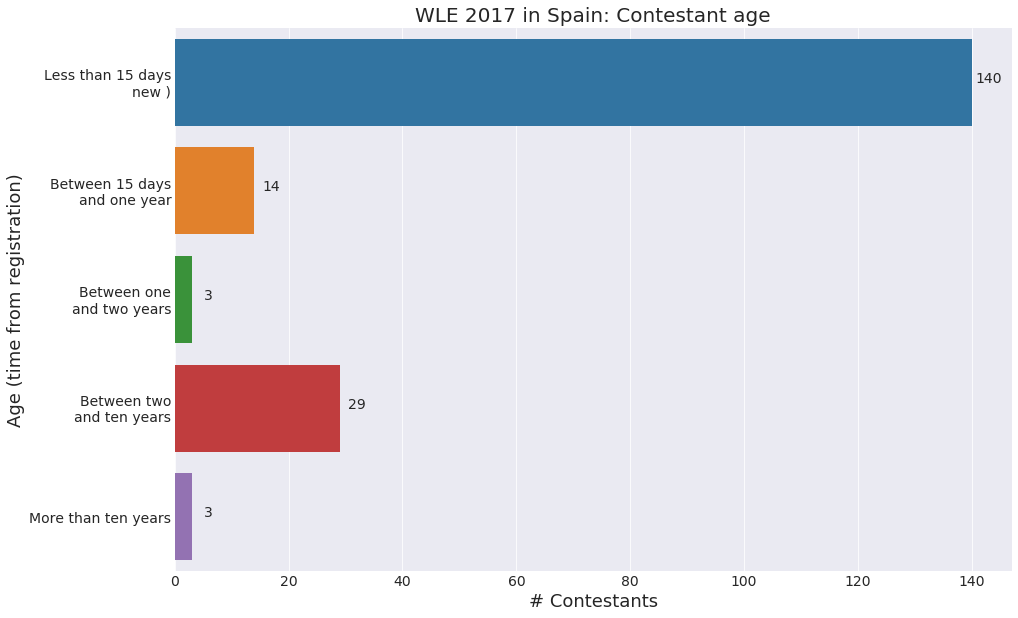

In [34]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=age.index, x=age.values)
p.set_xlabel("# Contestants", fontsize=18)
p.set_ylabel("Age (time from registration)", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contestant age'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_yticklabels(['Less than 15 days\nnew )', 
                   'Between 15 days\nand one year', 
                   'Between one\nand two years', 
                   'Between two\nand ten years', 
                   'More than ten years'])

for patch in ax.patches:
    ax.text(patch.get_width() + 3,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Contestant age.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contestant age. Time from registration to first contribution to contest.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

### New uploaders

In [41]:
new_uploaders = uploaders[uploaders<DAYS_BEFORE_REGISTRATION].index
new_uploaders

Index(['15230181h', 'ALR3641', 'AMADA MARTINEZ GOMEZ', 'APerdi', 'Adrylaur',
       'Albasilv', 'Alejandro.g.sz', 'Alexis de Arce', 'Aliciaderksen',
       'Andrey Tenerife',
       ...
       'Tenerifetrade', 'The man who shot liberty valance', 'Tommasocherubini',
       'Troesel', 'Unaberta', 'Vbenmont', 'Ventayol', 'Xoc3', 'Yerie2017',
       'Yolandoska'],
      dtype='object', name='uploader', length=140)

In [42]:
new_uploaders_length = len(new_uploaders)
new_uploaders_length

140

### Images by uploader

In [43]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader = images_per_uploader.iloc[np.lexsort([images_per_uploader.index, -images_per_uploader.values])]
images_per_uploader

Fedoce1                             192
MACfoto1963                         124
Tanja 007                           123
Dorieo                               75
The man who shot liberty valance     74
Discasto                             73
Nandicus                             71
Songbird8                            67
Aglaya72                             64
AnaisGoepner                         60
Madixator                            60
Iagocasabiell                        54
Srg1989                              53
Colsandsol                           43
MACfoto63                            41
Carmen Sanz Cabedo                   40
Gbcoronadoh                          35
MaS10TeR                             33
15230181h                            32
Vanbasten 23                         32
JUANALBE                             31
Yerie2017                            30
19Tarrestnom65                       29
Careerfromhome                       29
Ejmillan                             29


In [44]:
new_uploaders_contributions = images_per_uploader[new_uploaders]
new_uploaders_contributions

uploader
15230181h                           32
ALR3641                             15
AMADA MARTINEZ GOMEZ                 2
APerdi                               4
Adrylaur                             2
Albasilv                             2
Alejandro.g.sz                       2
Alexis de Arce                      16
Aliciaderksen                        1
Andrey Tenerife                     23
Angela Llop                         27
Angela003                            3
Architectzaker                       5
Aregatero26                          5
Audalix                             17
Av remi04                           10
Aveima                               2
BrendanRyanII                       14
Cardenasaaron                       16
Carla.Martina07                      2
Clanzas                              6
ClauFran03                           4
ColibriSpain                         3
Colsandsol                          43
Crestofono Ofono                     1
Cristina Souto  

In [46]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS = 16

In [48]:
remaining_images_per_uploader = images_per_uploader[:TOP_UPLOADERS]
remaining_images_per_uploader

Fedoce1                             192
MACfoto1963                         124
Tanja 007                           123
Dorieo                               75
The man who shot liberty valance     74
Discasto                             73
Nandicus                             71
Songbird8                            67
Aglaya72                             64
AnaisGoepner                         60
Madixator                            60
Iagocasabiell                        54
Srg1989                              53
Colsandsol                           43
MACfoto63                            41
Carmen Sanz Cabedo                   40
Name: images, dtype: int64

[[commons:File:WLE 2017 in Spain - Top authors.png]]


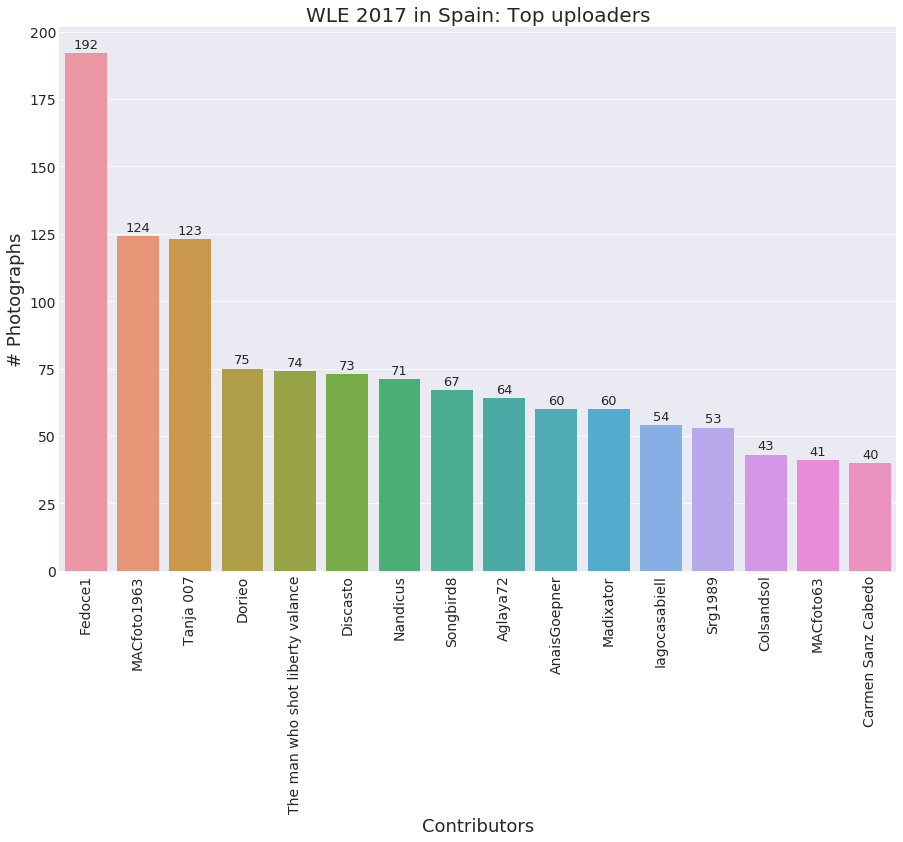

In [49]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_per_uploader.index, y=remaining_images_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 2,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [50]:
images_df['uploader'].unique()

array(['Javieralbertos', 'Miquel1004', 'Mikipons', 'Cardenasaaron',
       'Bufoga', 'MACfoto1963', '15230181h', 'Merdaseca',
       'Maroto el bellaco', 'Ejmillan', 'Gbcoronadoh', 'Iriartejaialai',
       'Yerie2017', 'Juan Lobo', 'Discasto', 'Madixator', 'EeBfD 007',
       'Pilarillan', 'David.lopezgo9985', 'MACfoto63', 'Dorieo', 'APerdi',
       'Colsandsol', 'Nandicus', 'Angela Llop', 'Eafosan',
       'The man who shot liberty valance', 'AMADA MARTINEZ GOMEZ',
       'Croonenberghs', 'Andrey Tenerife', 'Lulusao5', 'Srg1989',
       'Tanja 007', 'Jdelahid', 'R mano', 'Susana Garzón', 'Av remi04',
       'Carmen Sanz Cabedo', 'Jenniferveramartin', 'Elfrankgonzalez',
       'Mabi1403', 'Jenni sv', 'Emejota3', 'Tommasocherubini', 'Jesus627',
       'Amfeli', 'Aliciaderksen', 'Joaquín Matos Morales', 'REFLEX MBN',
       'Eckhard', 'Salo94', 'Havista', 'Mekong56', 'Alexis de Arce',
       'F.vazquez.86', 'Pinilla.jesus', 'Juanluss31', 'Nasasmi',
       'Maria missae', 'Sherwik', 'Areg

In [52]:
valid_images_length = len(images_df[images_df['code'].isin(valid_sites)].index)
valid_images_length

2386

In [53]:
images_df[images_df['code'].isin(valid_sites)]['code'].unique()

array(['ES0000001', 'ES5310125', 'ES5110012', 'ES0000035', 'ES1200001',
       'ES4250001', 'ES0000018', 'ES4110002', 'ES3110004', 'ES0000160',
       'ES5310100', 'ES2120014', 'ES1110001', 'ES0000111', 'ES4150096',
       'ES6140004', 'ES4150085', 'ES7010007', 'ES5213023', 'ES5213033',
       'ES1120007', 'ES2120016', 'ES0000019', 'ES0000022', 'ES4320031',
       'ES0000023', 'ES4170144', 'ES6170007', 'ES2200019', 'ES0000047',
       'ES5110022', 'ES5120001', 'ES7020104', 'ES4210008', 'ES0000058',
       'ES7020043', 'ES6200002', 'ES7020095', 'ES7020046', 'ES2410002',
       'ES4130010', 'ES1120001', 'ES4320038', 'ES0000166', 'ES0000046',
       'ES0000027', 'ES3110002', 'ES6170010', 'ES5130005', 'ES3110005',
       'ES0000053', 'ES0000013', 'ES0000060', 'ES1300003', 'ES1130002',
       'ES5120015', 'ES6120008', 'ES7010041', 'ES2410025', 'ES1120003',
       'ES6130007', 'ES1200009', 'ES5140009', 'ES7010019', 'ES0000147',
       'ES5110017', 'ES5310030', 'ES5310045', 'ES5310099', 'ES61

### Sites by uploader

In [54]:
sites_per_uploader_df = images_df[images_df['code'].isin(valid_sites)].\
                                    groupby(['uploader']).\
                                    agg({"code": pd.Series.nunique}).\
                                    sort_values('code', ascending=False)
sites_per_uploader = sites_per_uploader_df["code"]
sites_per_uploader = sites_per_uploader.rename('sites')
sites_per_uploader = sites_per_uploader.iloc[np.lexsort([sites_per_uploader.index, -sites_per_uploader.values])]
sites_per_uploader

uploader
Aglaya72                            62
AnaisGoepner                        30
MACfoto1963                         21
Colsandsol                          16
Tanja 007                           12
Fedoce1                             11
Eafosan                             10
Iagocasabiell                       10
Mario peces                         10
Angela Llop                          9
REFLEX MBN                           9
Discasto                             8
Yerie2017                            8
Iriartejaialai                       7
JesusLucena27                        7
Mikipons                             7
15230181h                            6
Amfeli                               6
Gbcoronadoh                          6
Lulusao5                             6
Merdaseca                            6
Srg1989                              6
Carmen Sanz Cabedo                   5
Eckhard                              5
Ejmillan                             5
MACfoto63       

In [55]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS_BY_SITE = 16

In [57]:
wle_sites_length = images_df[images_df['code'].isin(valid_sites)]['code'].unique().size
wle_sites_length

307

[[commons:File:WLE 2017 in Spain - Top authors by site of community importance.png]]


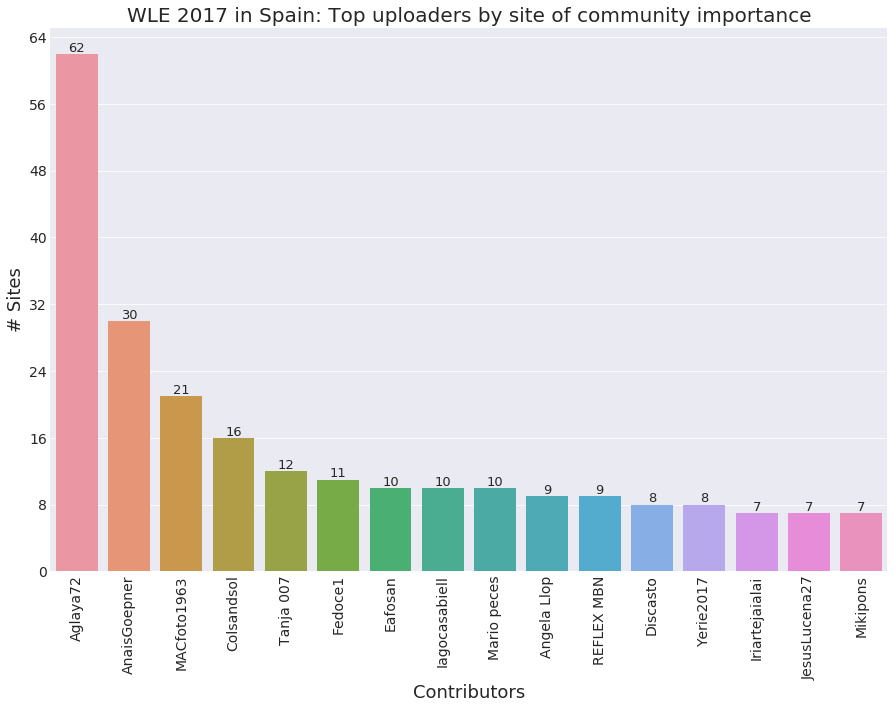

In [58]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=sites_per_uploader[:TOP_UPLOADERS_BY_SITE].index, 
                y=sites_per_uploader[:TOP_UPLOADERS_BY_SITE].values
               )
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Sites", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders by site of community importance'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.yaxis.set_major_locator(MaxNLocator(integer=True))

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.3,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors by site of community importance.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS_BY_SITE),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [59]:
uploaders_df = pd.concat([sites_per_uploader, images_per_uploader], axis=1).fillna(0)
uploaders_df.columns=['Sites', 'Photographs']
uploaders_df['Sites'] = uploaders_df['Sites'].astype(int)
uploaders_df = uploaders_df.iloc[np.lexsort([uploaders_df.index, -uploaders_df['Photographs']])]
uploaders_df

,Sites,Photographs
Fedoce1,11,192
MACfoto1963,21,124
Tanja 007,12,123
Dorieo,2,75
The man who shot liberty valance,5,74
Discasto,8,73
Nandicus,5,71
Songbird8,4,67
Aglaya72,62,64
AnaisGoepner,30,60


[[commons:File:WLE 2017 in Spain - Top authors (2).png]]


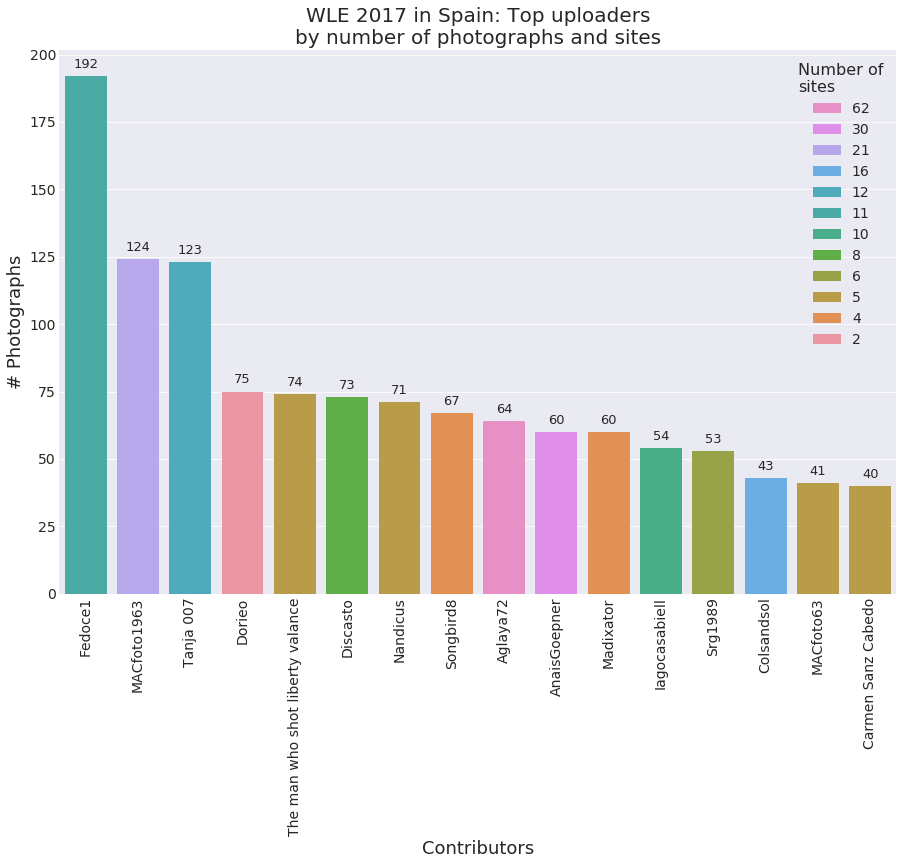

In [60]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=uploaders_df[:TOP_UPLOADERS].index, 
                y=uploaders_df[:TOP_UPLOADERS]['Photographs'], 
                hue=uploaders_df[:TOP_UPLOADERS]['Sites'],
                dodge=False)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders\nby number of photographs and sites'.format(YEAR, TAG), fontsize=20)

p.tick_params(labelsize=14)
p.set_xticklabels(p.get_xticklabels(), rotation=90)

handles, labels = p.get_legend_handles_labels()
handles.reverse()
labels.reverse()

legend = plt.legend(loc='upper right', 
                    title='Number of\nsites', 
                    fontsize=14,
                    labels=labels,
                    handles=handles)
plt.setp(legend.get_title(), fontsize=16)

for patch in p.patches:
    height = patch.get_height()
    if not math.isnan(height):
        p.text(patch.get_x() + patch.get_width()/2.,
                height + 3,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (2).png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain with contribution to sites'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

## Contributions by day

In [61]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df['image_title'].resample('d').count()
upload_ts[datetime(YEAR, 5, 31)] = upload_ts[datetime(YEAR, 5, 31)] + upload_ts[datetime(YEAR, 6, 1)]
upload_ts.drop(datetime(YEAR, 6, 1), inplace=True)
upload_ts = pd.Series([0]*31, index = pd.date_range(datetime(YEAR, 5, 1), periods=31, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

2017-04-20      0
2017-04-21      0
2017-04-22      0
2017-04-23      0
2017-04-24      0
2017-04-25      0
2017-04-26      0
2017-04-27      0
2017-04-28      0
2017-04-29      0
2017-04-30      0
2017-05-01     58
2017-05-02     28
2017-05-03     72
2017-05-04     20
2017-05-05     19
2017-05-06     10
2017-05-07     40
2017-05-08     41
2017-05-09     17
2017-05-10    113
2017-05-11      9
2017-05-12     53
2017-05-13     39
2017-05-14     85
2017-05-15     21
2017-05-16     42
2017-05-17     53
2017-05-18     66
2017-05-19     41
2017-05-20     15
2017-05-21     76
2017-05-22     11
2017-05-23     85
2017-05-24    171
2017-05-25     70
2017-05-26     78
2017-05-27     75
2017-05-28    221
2017-05-29     67
2017-05-30    452
2017-05-31    344
Freq: D, dtype: int64

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Images uploaded to WLE 2017 in Spain by day}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-02-21
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE 2017 in Spain - Uploads by day.png successful.

1 pages read
1 pages written
Script terminated successfully.


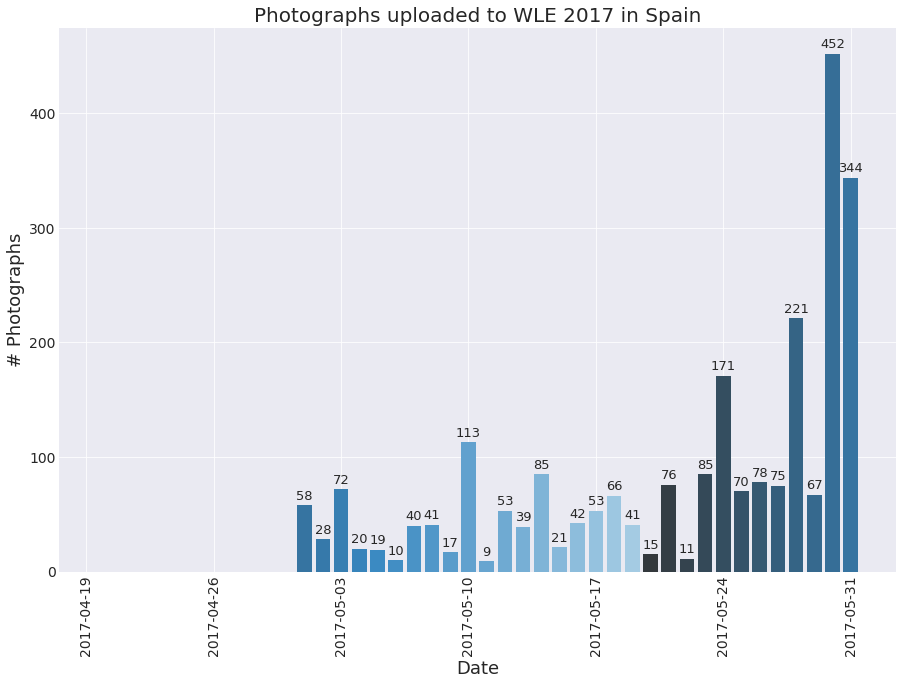

In [62]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 30))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain'.format(YEAR, TAG), fontsize=20)

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 5,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day.png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

## MediaWiki tables creation

In [63]:
# Dataframe merge (images and sites)
images_extended_df = pd.merge(images_df, sci_df, on='code', how='left')
len(images_extended_df.index)

2493

### New uploaders

In [64]:
new_uploaders_contributions = images_per_uploader[new_uploaders]
new_uploaders_contributions

uploader
15230181h                           32
ALR3641                             15
AMADA MARTINEZ GOMEZ                 2
APerdi                               4
Adrylaur                             2
Albasilv                             2
Alejandro.g.sz                       2
Alexis de Arce                      16
Aliciaderksen                        1
Andrey Tenerife                     23
Angela Llop                         27
Angela003                            3
Architectzaker                       5
Aregatero26                          5
Audalix                             17
Av remi04                           10
Aveima                               2
BrendanRyanII                       14
Cardenasaaron                       16
Carla.Martina07                      2
Clanzas                              6
ClauFran03                           4
ColibriSpain                         3
Colsandsol                          43
Crestofono Ofono                     1
Cristina Souto  

### Authors dataframe

In [65]:
valid_images_per_uploader = images_df[images_df['code'].isin(valid_sites)]['uploader'].value_counts()
valid_images_per_uploader = valid_images_per_uploader.rename('valid_images')
valid_images_per_uploader = valid_images_per_uploader.iloc[np.lexsort([valid_images_per_uploader.index, -valid_images_per_uploader.values])]
valid_images_per_uploader

Fedoce1                             192
MACfoto1963                         124
Tanja 007                           123
Dorieo                               75
Nandicus                             71
Discasto                             70
Songbird8                            67
The man who shot liberty valance     67
Aglaya72                             64
AnaisGoepner                         60
Madixator                            60
Iagocasabiell                        54
Srg1989                              53
MACfoto63                            41
Carmen Sanz Cabedo                   40
Gbcoronadoh                          35
Colsandsol                           33
MaS10TeR                             33
Vanbasten 23                         32
Yerie2017                            30
19Tarrestnom65                       29
Careerfromhome                       29
Ejmillan                             29
Malopez 21                           28
Angela Llop                          24


In [68]:
site_list_per_uploader = images_extended_df[images_extended_df['code'].isin(valid_sites)]\
                                                                      .groupby('uploader')['code']\
                                                                      .apply(set)\
                                                                      .apply(lambda x: filter(None, x))\
                                                                      .apply(lambda x: expand_itemid(x))\
                                                                      .rename('site_list', inplace=True)
site_list_per_uploader

uploader
15230181h                           [{'itemid': 'ES2120016', 'name': 'Aiako harria...
19Tarrestnom65                      [{'itemid': 'ES4230013', 'name': 'Hoces del Ca...
ALR3641                             [{'itemid': 'ES3110002', 'name': 'Cuenca del r...
AMADA MARTINEZ GOMEZ                [{'itemid': 'ES0000058', 'name': 'El Fondo d'E...
APerdi                              [{'itemid': 'ES0000023', 'name': 'L'Albufera'}...
Adrylaur                              [{'itemid': 'ES0000023', 'name': 'L'Albufera'}]
Aglaya72                            [{'itemid': 'ES6170002', 'name': 'Acantilados ...
Albasilv                            [{'itemid': 'ES1140015', 'name': 'Sobreirais d...
Alejandro.g.sz                      [{'itemid': 'ES6150019', 'name': 'Bajo Guadalq...
Alexis de Arce                      [{'itemid': 'ES1120003', 'name': 'Parga - Ladr...
Aliciaderksen                       [{'itemid': 'ES1300003', 'name': 'Rias occiden...
Amfeli                              [{'itemid

In [69]:
authors_df = pd.concat([images_per_uploader, valid_images_per_uploader, sites_per_uploader, site_list_per_uploader], axis=1)\
               .sort_values(by='images', ascending=False)\
               .reset_index()\
               .rename(columns = {'index': 'contestant'})

authors_df[['images', 'valid_images', 'sites']] = authors_df[['images', 'valid_images', 'sites']]\
                                                                        .fillna(0)\
                                                                        .astype('int')

authors_df = authors_df.iloc[np.lexsort([authors_df['contestant'], -authors_df['images']])]
authors_df['registration_string'] = authors_df['contestant'].map(lambda x: get_registration_time(x))
authors_df['site_list'] = authors_df['site_list'].map(lambda x: decode_list(x))
authors_df

,contestant,images,valid_images,sites,site_list,registration_string
0,Fedoce1,192,192,11,"[{'itemid': 'ES0000140', 'name': 'Bahía de Cád...",2017-05-23
1,MACfoto1963,124,124,21,"[{'itemid': 'ES0000166', 'name': 'Barranco del...",2017-05-23
2,Tanja 007,123,123,12,"[{'itemid': 'ES1120001', 'name': 'Ancares - Co...",2015-05-28
3,Dorieo,75,75,2,"[{'itemid': 'ES5213019', 'name': 'Aitana, Serr...",2008-07-20
4,The man who shot liberty valance,74,67,5,"[{'itemid': 'ES4210001', 'name': 'Hoces del rí...",2017-05-10
5,Discasto,73,70,8,"[{'itemid': 'ES4150096', 'name': 'Arribes del ...",2014-03-02
6,Nandicus,71,71,5,"[{'itemid': 'ES2410059', 'name': 'El Turbón'},...",2017-05-20
7,Songbird8,67,67,4,"[{'itemid': 'ES0000239', 'name': 'De Binigaus ...",2016-11-29
8,Aglaya72,64,64,62,"[{'itemid': 'ES6170002', 'name': 'Acantilados ...",2014-08-30
9,AnaisGoepner,60,60,30,"[{'itemid': 'ES4150096', 'name': 'Arribes del ...",2013-09-23


### Images by site dataframe

In [70]:
images_per_site = images_extended_df[images_extended_df['code'].isin(valid_sites)]['code'].value_counts()
images_per_site

ES0000035    72
ES0000023    68
ES4110002    58
ES1110005    45
ES3110002    43
ES1200001    42
ES7020043    38
ES0000031    38
ES0000001    36
ES6140004    36
ES1130002    35
ES0000126    35
ES0000337    34
ES4250001    34
ES5110024    33
ES0000049    33
ES6170007    33
ES4140053    33
ES5110025    32
ES4210005    31
ES6170003    29
ES7010039    29
ES0000016    29
ES0000140    28
ES0000234    27
ES1110002    26
ES0000237    26
ES4210008    26
ES4210001    25
ES1120005    24
             ..
ES4230005     1
ES6150026     1
ES7010031     1
ES2120002     1
ES5140021     1
ES2430043     1
ES5120008     1
ES4160122     1
ES2120009     1
ES1200043     1
ES6200003     1
ES1300015     1
ES5213018     1
ES7010054     1
ES6180002     1
ES1200011     1
ES1110011     1
ES5310082     1
ES4190105     1
ES4240018     1
ES5221002     1
ES4320077     1
ES2200043     1
ES1200032     1
ES0000082     1
ES0000025     1
ES5130036     1
ES0000164     1
ES7020104     1
ES4170144     1
Name: code, Length: 307,

In [71]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of festivals with more than 15 pictures
TOP_SITES = 20

In [72]:
images_per_site_df = pd.DataFrame(data=images_per_site).reset_index()
images_per_site_df.rename(columns={'index': 'code', 'code': 'count'}, inplace=True)

In [73]:
images_per_site_df = pd.merge(images_per_site_df, sci_df, on='code')[['count', 'code', 'name', 'aut_com', 'latitude', 'longitude']].fillna('')
images_per_site_df = images_per_site_df.iloc[np.lexsort([images_per_site_df['name'], -images_per_site_df['count']])]
images_per_site_df['name'] = images_per_site_df['name'].map(lambda x: x.replace('_', ' '))
images_per_site_df.head()

,count,code,name,aut_com,latitude,longitude
0,72,ES0000035,"Sierras de Cazorla, Segura y Las Villas",Andalusia,38.098537,-2.763514
1,68,ES0000023,L'Albufera,Valencian Community,39.305300,-0.313100
2,58,ES4110002,Sierra de Gredos,Castile and León,40.273300,-5.330300
3,45,ES1110005,Costa da Morte,Galicia,42.867300,-9.249500
4,43,ES3110002,Cuenca del río Lozoya y Sierra Norte,Community of Madrid,40.941400,-3.703600


In [74]:
compact_images_per_site = images_per_site_df[:TOP_SITES][['count', 'name']]
compact_images_per_site = compact_images_per_site.iloc[np.lexsort([compact_images_per_site['name'], -compact_images_per_site['count']])]
compact_images_per_site['name'] = compact_images_per_site['name'].map(lambda x: wrap_label(x, 20))
compact_images_per_site

,count,name
0,72,"Sierras de Cazorla,\nSegura y Las Villas"
1,68,L'Albufera
2,58,Sierra de Gredos
3,45,Costa da Morte
4,43,Cuenca del río\nLozoya y Sierra\nNorte
5,42,Picos de Europa\n(Asturias)
6,38,Parque Nacional del\nTeide
7,38,Sierra de Grazalema
8,36,Illas Cíes
9,36,Sierra Nevada


[[commons:File:WLE 2017 in Spain - Top sites of community importance.png]]


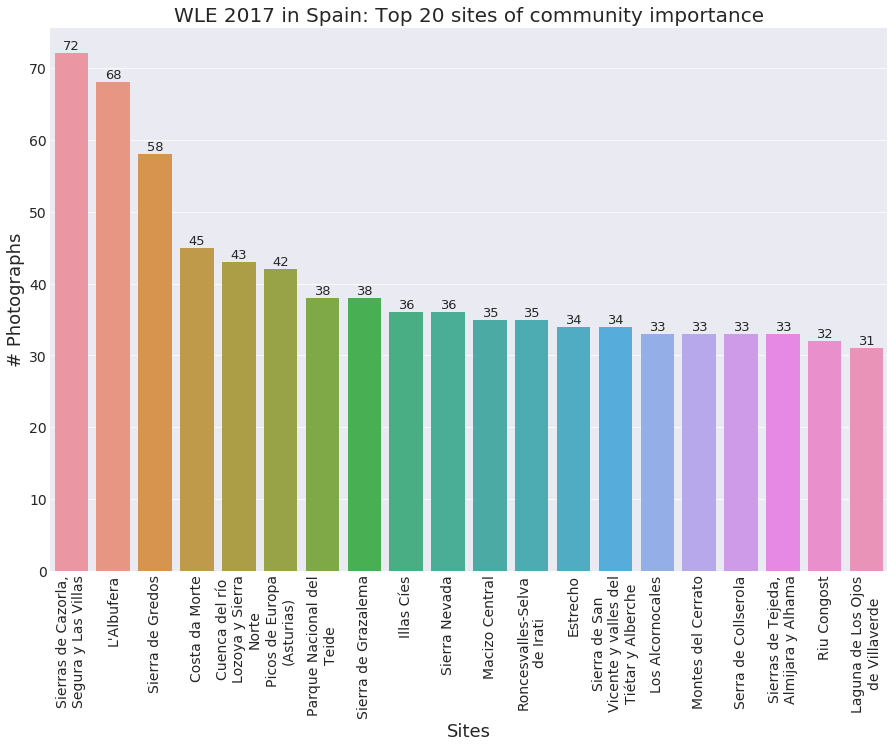

In [75]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=compact_images_per_site, x='name', y='count')
p.set_xlabel("Sites", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top {2} sites of community importance'.format(YEAR, TAG, TOP_SITES), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.5,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top sites of community importance.png".format(YEAR, TAG),
                  'Top {2} sites of community importance in {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_SITES),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

## Map creation

In [76]:
images_per_site_df['geojson'] = images_per_site_df.apply(lambda row: to_geojson(row), axis=1)

In [77]:
features = images_per_site_df['geojson'].tolist()
feature_collection = FeatureCollection(features)
dump = geojson.dumps(feature_collection, ensure_ascii=False, indent=2)
#print(dump)

## Autonomous Communities

In [79]:
sites_per_autcom = images_per_site_df.groupby(['aut_com']).\
                                              count().\
                                              sort_values(by='count', ascending=False).\
                                              reset_index()[['aut_com', 'count']]
sites_per_autcom['aut_com'] = sites_per_autcom['aut_com'].map(lambda x: wrap_label(x, 14))
sites_per_autcom

,aut_com,count
0,Andalusia,38
1,Catalonia,38
2,Castile and\nLeón,35
3,Canary Islands,25
4,Galicia,25
5,Castile-La\nMancha,25
6,Valencian\nCommunity,23
7,Aragon,14
8,Balearic\nIslands,14
9,Cantabria,13


In [80]:
aut_coms = len(sites_per_autcom.index)
aut_coms

17

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Sites of Community Importance by autonomous community in Wiki Loves Earth 2017 in Spain}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-02-21
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE 2017 in Spain - Sites of Community Importance by autonomous community.png successful.

1 pages read
1 pages written
Script terminated successfully.


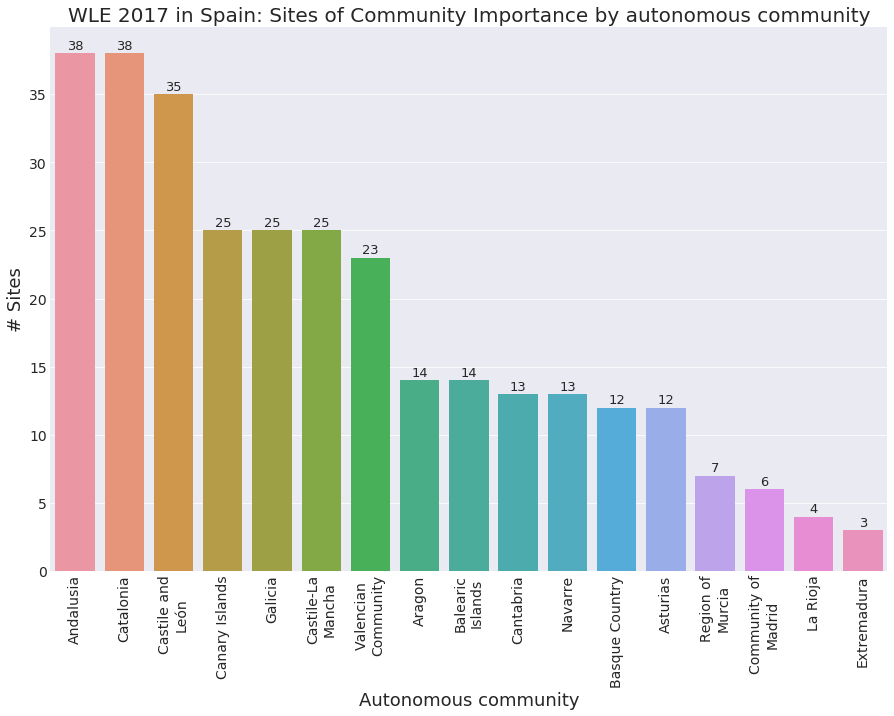

In [81]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=sites_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous community", fontsize=18)
p.set_ylabel("# Sites", fontsize=18)

p.set_title(label='{1} {0} in Spain: Sites of Community Importance by autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.3,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Sites of Community Importance by autonomous community.png".format(YEAR, TAG),
                  'Sites of Community Importance by autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [82]:
images_per_autcom = images_per_site_df.groupby(['aut_com']).\
                     sum().\
                     sort_values(by='count', ascending=False).\
                     reset_index()
images_per_autcom

,aut_com,count,latitude,longitude
0,Andalusia,482,1411.230735,-173.103573
1,Galicia,307,1074.178900,-204.655000
2,Castile-La Mancha,248,996.834445,-63.231111
3,Castile and León,233,1454.962800,-158.428900
4,Catalonia,225,1588.532058,66.881934
5,Valencian Community,181,894.570467,-8.197666
6,Canary Islands,146,708.860870,-392.914550
7,Balearic Islands,111,555.231360,45.503711
8,Community of Madrid,105,243.251200,-22.820300
9,Aragon,81,589.927400,-6.120545


The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Photographs by autonomous community in Wiki Loves Earth 2017 in Spain}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-02-21
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE 2017 in Spain - Photographs by autonomous community.png successful.

1 pages read
1 pages written
Script terminated successfully.


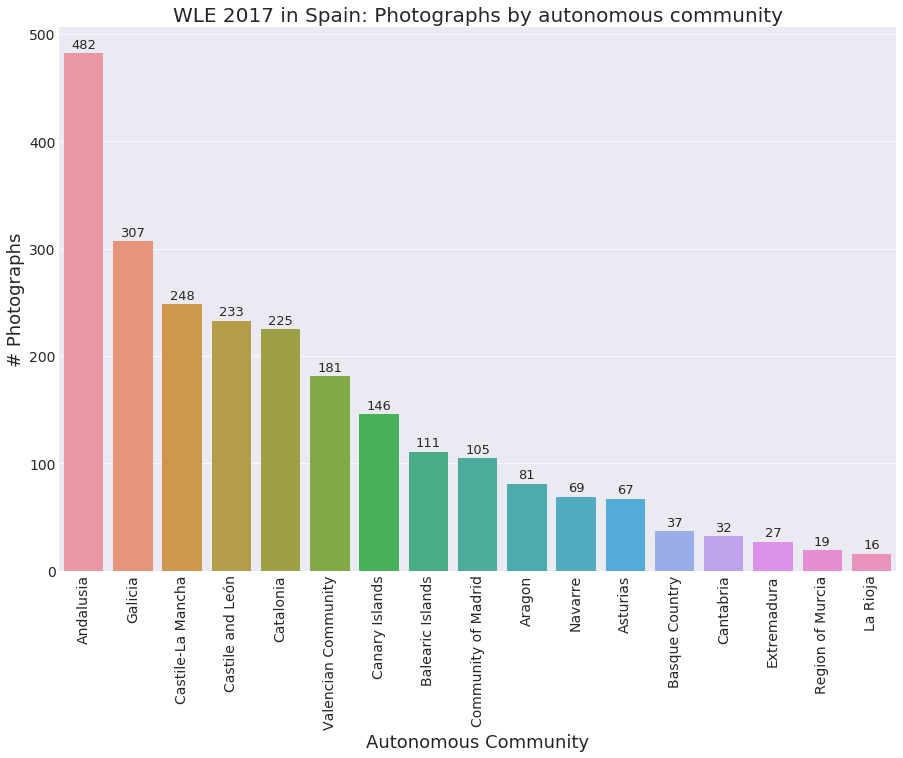

In [83]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=images_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous Community", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Photographs by autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 5,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Photographs by autonomous community.png".format(YEAR, TAG),
                  'Photographs by autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

## Usage management

In [84]:
n=5
list_df = [images_df[i:i+n] for i in range(0, images_df.shape[0], n)]
usage_dict = {}

counter = 0
for df in list_df :
    query_string_items = list()
    for _, row in df.iterrows():
        title = 'File:{0}'.format(row["image_title"])
        query_string_items.append(title)
    raw_api_query_string = '|'.join(query_string_items)
    MW_API_QUERY_STRING["titles"] = raw_api_query_string
    
    r = requests.post(MW_API_BASE_URL, data=urlencode(MW_API_QUERY_STRING))
    response = r.text

    try:
        response_dict = json.loads(response)
        for _, value in response_dict["query"]["pages"].items():
            uses_dict = value['globalusage']
            tuples = [(item['wiki'], 1) for item in uses_dict if (item['ns'] in VALID_NAMESPACES)]
            summary = [reduce(lambda x, y: (x[0], x[1]+y[1]), group) for _, group in groupby(sorted(tuples), key=itemgetter(0))]
            if len(summary) > 0 :
                counter +=1
                title = value['title'].replace('File:', '')
                summary_dict = {tuple[0]: tuple[1] for tuple in summary}
                usage_dict.update({title: summary_dict})
    except :
        print ('Error found')
        pass

Error found


In [85]:
# unique images used
usage_df = pd.DataFrame(usage_dict).transpose()
total_unique=usage_df.count(axis=1).count()
total_unique

147

In [86]:
# summary table
usages_df = pd.concat([usage_df.sum(), usage_df.count()], axis=1)
usages_df.columns = ['usages', 'unique']
usages_df['usages'] = usages_df['usages'].astype(int)
usages_df.sort_values(by=['unique'], axis=0, ascending=False, inplace=True)
usages_df['name'] = usages_df.index
usages_df['name'] = usages_df['name'].map(get_project_name)
usages_df.set_index(['name'], inplace=True)
usages_df = usages_df.iloc[np.lexsort([usages_df.index, -usages_df['unique']])]
usages_df

,usages,unique
name,,
Spanish Wikipedia,68,58
English Wikipedia,32,31
Wikidata,35,31
Catalan Wikipedia,14,14
Galician Wikipedia,14,13
Basque Wikipedia,13,10
Cebuano Wikipedia,12,10
Swedish Wikipedia,9,9
French Wikipedia,8,8


In [87]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of projects with more than 1 picture
TOP_PROJECTS = 15

In [88]:
remaining_df = pd.DataFrame(usages_df.iloc[TOP_PROJECTS:].sum()).transpose()
other_projects_num = len(usages_df.index)-TOP_PROJECTS
remaining_df.index=['Other projects ({})'.format(other_projects_num)]
top_df = usages_df.iloc[:TOP_PROJECTS]
reduced_usages_df = top_df.append(remaining_df)
reduced_usages_df

,usages,unique
Spanish Wikipedia,68,58
English Wikipedia,32,31
Wikidata,35,31
Catalan Wikipedia,14,14
Galician Wikipedia,14,13
Basque Wikipedia,13,10
Cebuano Wikipedia,12,10
Swedish Wikipedia,9,9
French Wikipedia,8,8
German Wikipedia,7,6


The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Unique photographs from Wiki Loves Earth 2017 in Spain used in WMF projects: top 12 projects}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-02-21
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE 2017 in Spain - Unique photographs used in WMF projects.png successful.

1 pages read
1 pages written
Script terminated successfully.


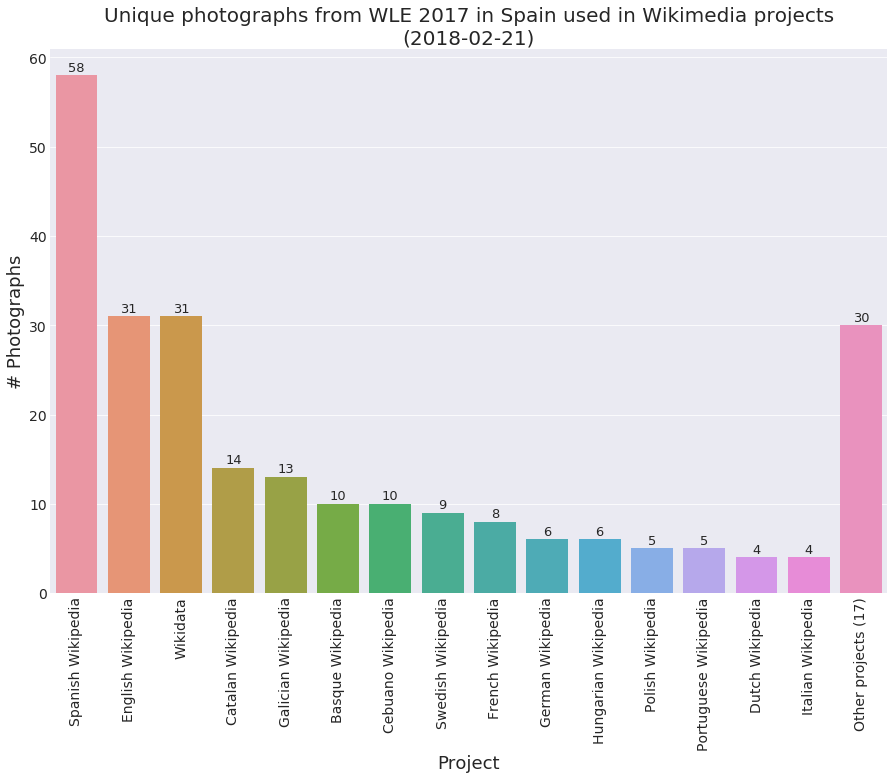

In [89]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='unique', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Unique photographs from {2} {0} in Spain used in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.5,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Unique photographs used in WMF projects.png".format(YEAR, TAG),
                  'Unique photographs from {1} {0} in Spain used in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Uses of photographs from Wiki Loves Earth 2017 in Spain in WMF projects: top 12 projects}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2018-02-21
}}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Sleeping for 3.9 seconds, 2018-02-21 16:04:50
Upload successful.
Upload of WLE 2017 in Spain - Uses of photographs in WMF projects.png successful.

1 pages read
1 pages written
Script terminated successfully.


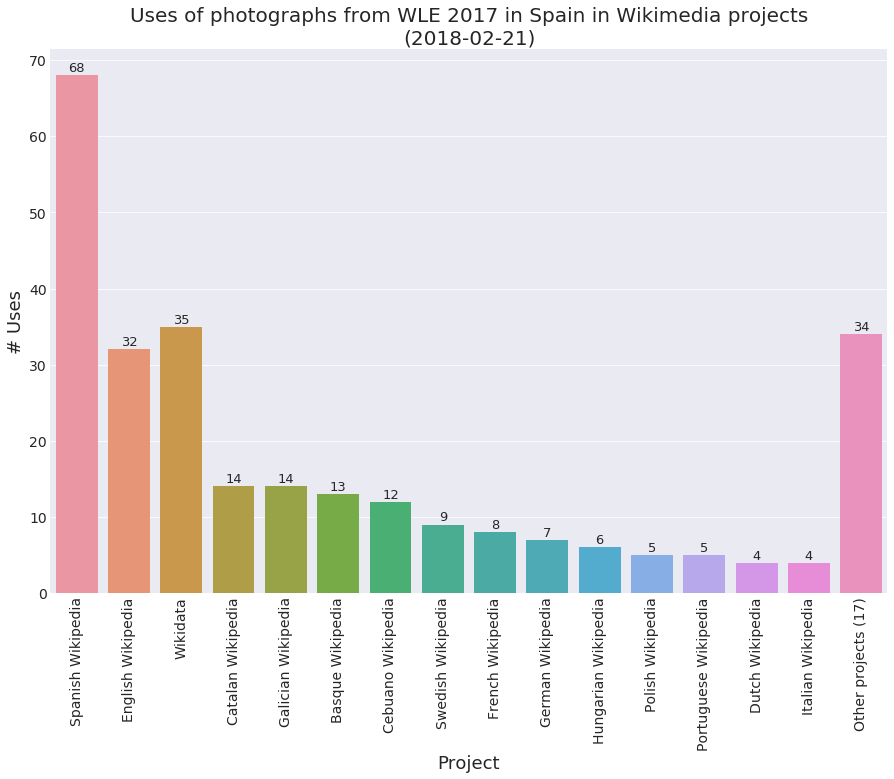

In [90]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='usages', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Uses", fontsize=18)

p.set_title(label='Uses of photographs from {2} {0} in Spain in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.5,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Uses of photographs in WMF projects.png".format(YEAR, TAG),
                  'Uses of photographs from {1} {0} in Spain in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

## Quality Images

In [91]:
# Quality images gallery
template = """This page lists the ${len(QI_list)} '''[[Commons:Quality Images|quality images]]''' uploaded as part of the 
[[Commons:${tag}|${tag}]] contest in ${year} in Spain.

<gallery>
% for image in QI_list:
${image}
% endfor
</gallery>

'''Statistics generation date''': {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}

[[Category:${tag} in Spain| Quality]]

"""
vars = {
    "QI_list": qi_list.values,
    "tag": TAG_EXT,
    "year": YEAR
}
t = Template(template)
qi_gallery_text = t.render(**vars)

In [92]:
qi_page = pb.Page(commons_site, GALLERY_QI)
if qi_page.text != qi_gallery_text:
    qi_page.text = qi_gallery_text
    pb.output('Publishing --> {1} {0} in Spain featured articles gallery'.format(YEAR, TAG))
    qi_page.save("{1} {0} in Spain featured articles gallery".format(YEAR, TAG))

Publishing --> WLE 2017 in Spain featured articles gallery
Sleeping for 6.1 seconds, 2018-02-21 16:04:58
Page [[commons:Commons:Wiki Loves in Spain/Wiki Loves Earth/2017/QI]] saved


## Coverage

In [93]:
coverage_totals = sci_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['aut_com'].count()
coverage_category = sci_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['commons_cat'].count()
coverage_images = sci_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['image'].count()

coverage_df = pd.concat([sci_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['aut_com'].count(),
                        sci_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['commons_cat'].count(),
                        sci_df[['aut_com', 'commons_cat', 'image']].groupby(['aut_com'])['image'].count()], axis=1)
total_coverage = coverage_df.sum(numeric_only=True).rename('Total')
coverage_df = coverage_df.append(total_coverage)

coverage_df['aut_com'] = coverage_df['aut_com'].fillna(0).astype('int')
coverage_df['category_percentage'] = (100.*coverage_df['commons_cat']/coverage_df['aut_com']).round(2)
coverage_df['image_percentage'] = (100.*coverage_df['image']/coverage_df['aut_com']).round(2)
coverage_df['commons_cat'] = coverage_df['commons_cat'].fillna(0).astype('int')
coverage_df['image'] = coverage_df['image'].fillna(0).astype('int')
coverage_df['image_color'] = coverage_df['image_percentage'].apply(heat_color)
coverage_df['cat_color'] = coverage_df['category_percentage'].apply(heat_color)

In [94]:
coverage_df

,aut_com,commons_cat,image,category_percentage,image_percentage,image_color,cat_color
aut_com,,,,,,,
Andalusia,189,121,120,64.02,63.49,d9ff66,d9ff66
Aragon,156,75,76,48.08,48.72,ffff66,ffff66
Asturias,49,40,39,81.63,79.59,66ff66,66ff66
Balearic Islands,138,138,90,100.00,65.22,d9ff66,668cff
Basque Country,52,45,44,86.54,84.62,66ff66,66ff66
Canary Islands,153,95,93,62.09,60.78,d9ff66,d9ff66
Cantabria,21,17,18,80.95,85.71,66ff66,66ff66
Castile and León,120,99,99,82.50,82.50,66ff66,66ff66
Castile-La Mancha,72,50,39,69.44,54.17,d9ff66,d9ff66


## Page generation

In [95]:
template_file = os.path.join(templates_directory, 'wle{0}.wiki'.format(YEAR))
fh = open(template_file, 'r', encoding = "utf-8")
template = fh.read()
fh.close()

In [96]:
vars = {
    "images_length": total_images_length,
    "valid_images_length": valid_images_length,
    "site_images_length": 0,
    "qi_length": qi_length,
    "gallery_quality_images": GALLERY_QI,
    "wle_sites_length": wle_sites_length,
    "authors_length": authors_length,
    "new_uploaders_length": new_uploaders_length,
    "site_length": site_length,
    "aut_coms": aut_coms,
    "authors_df": authors_df,
    "images_per_site_df": images_per_site_df,
    "usages_df": usages_df,
    "coverage_df": coverage_df,
    "total_unique": total_unique,
    "new_uploaders": new_uploaders_contributions,
    "new_uploaders_sum": new_uploaders_contributions.sum(),
    "map": dump,
    "year": YEAR,
    "tag": TAG,
    "full_tag": TAG_EXT,
    "base": BASE_NAME
}
t = Template(template)
statisticts_text = t.render(**vars)

In [97]:
#stats_page = pb.Page(commons_site, STATISTICS_PAGE)
stats_page = pb.Page(commons_site, 'User:Discasto/test')
stats_page.text = statisticts_text
pb.output('Publishing --> {1} {0} in Spain Statistics'.format(YEAR, TAG))
stats_page.save("{1} {0} in Spain statistics".format(YEAR, TAG))

Publishing --> WLE 2017 in Spain Statistics
Sleeping for 6.6 seconds, 2018-02-21 16:05:07
Page [[commons:User:Discasto/test]] saved
